In [0]:
#from __future__ import absolute_import, division, print_function, unicode_literals
#!pip install -q tensorflow-gpu==2.0.0-rc1

# Variational Autoencoder 

![대체 텍스트](https://drive.google.com/uc?id=1OCoK4me3T3EcaEm6H-MobpVG45LrNRrh)

## TensorFlow 및 기타 라이브러리 가져오기

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.datasets import mnist
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [0]:
# network parameters
reconstruct_dim=784
input_shape = (reconstruct_dim,)
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 50

## MNIST 데이터 셋 로드

In [7]:
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 # 이미지 픽셀의 모든 값을 0~1 사이로 정규화
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
 # 28x28 이미지를 크기 784의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape,x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784) (10000, 784)


## VAE 모델생성
![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

### (1) Encoder 생성




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_shape (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
encoder_hidden1 (Dense)         (None, 512)          401920      input_shape[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        encoder_hidden1[0][0]            
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            1026        encoder_hidden1[0][0]            
_________________________________________________________________________________________

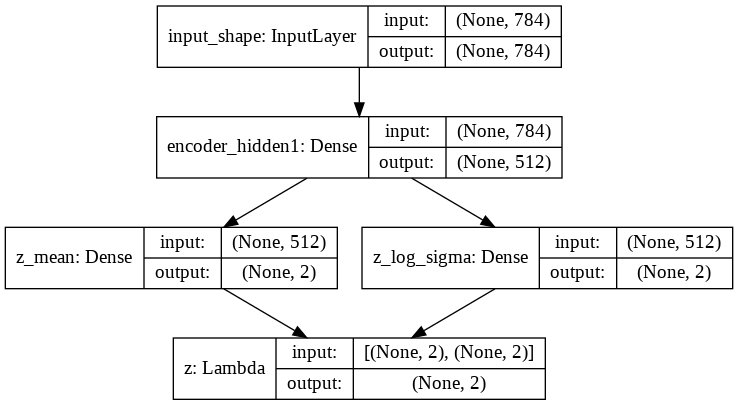

In [8]:
# Z 샘플링 함수 생성
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
# 인코더 모델을 생성합니다.
# 입력단에는 Input shape를 지정해줍니다.
inputs = Input(shape=input_shape, name='input_shape')
encoder_hidden = Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)
# 잠재변수Z에 사용할 평균(mean)과 표준편차(log_sigma) 정의합니다.  
z_mean = Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')(encoder_hidden)
# Lambda단에는 래핑에 사용할 함수와 출력 shape를 지정해줍니다.
z_sampling = Lambda(sampling, (latent_dim,), name='z')([z_mean, z_log_sigma])
# 인코더 모델은 다중 출력 모델이기 때문에 리스트를 사용하여 모델을 정의합니다.
encoder = Model(inputs,[z_mean,z_log_sigma,z_sampling], name='encoder')
# 인코더 네트워크를 확인합니다.
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

### (2) Decoder 생성

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_z (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 512)               1536      
_________________________________________________________________
output (Dense)               (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


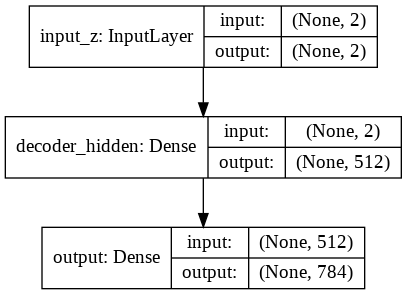

In [9]:
# 디코더 모델을 생성합니다.
# Z가 입력으로 들어오기 때문에 Z의 shape를 Input shape로 지정해줍니다.
input_z = Input(shape=(latent_dim,), name='input_z')
decoder_hidden = Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)
outputs = Dense(reconstruct_dim, activation='sigmoid',name='output')(decoder_hidden)

# 디코더 모델은 잠재변수 z가 입력으로 들어가고 복원값을 출력합니다. 
decoder = Model(input_z, outputs, name='decoder')

# 디코더의 네트워크를 확인합니다.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

### (3) VAE모델 생성



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


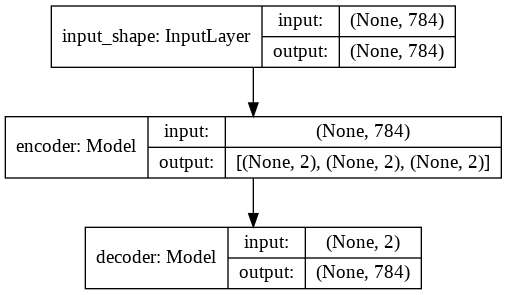

In [10]:
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    inputs, outputs = x, recon_x
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= reconstruct_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * K.sum(K.square(z_mean)+ K.exp(z_log_sigma)- 2*z_log_sigma -1, 1)    
    return K.mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

# build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

## 모델학습시작

In [11]:
history = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

#학습된 VAE 모델 저장 
vae.save_weights('vae_mlp_mnist.h5')




Train on 60000 samples, validate on 10000 samples
Epoch 1/20





60000/60000 [==============================] - 11s 190us/step - loss: 190.5117 - val_loss: 173.0659
Epoch 2/20
60000/60000 [==============================] - 6s 101us/step - loss: 170.4939 - val_loss: 168.9728
Epoch 3/20
60000/60000 [==============================] - 6s 99us/step - loss: 167.2877 - val_loss: 166.3770
Epoch 4/20
60000/60000 [==============================] - 6s 99us/step - loss: 165.1047 - val_loss: 164.4220
Epoch 5/20
60000/60000 [==============================] - 6s 100us/step - loss: 163.2617 - val_loss: 163.0148
Epoch 6/20
60000/60000 [==============================] - 6s 99us/step - loss: 161.8538 - val_loss: 161.8651
Epoch 7/20
60000/60000 [==============================] - 6s 100us/step - loss: 160.7863 - val_loss: 160.7205
Epoch 8/20
60000/60000 [==============================] - 6s 101us/step - loss: 159.9141 - val_loss: 160.2464
Epoch 9/20
60000/60000 [==============================] - 6s 100

## 학습 그래프 확인

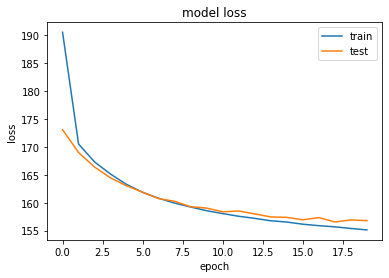

In [12]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
plt_hist(history)

## 원본이미지와 복원이미지 비교

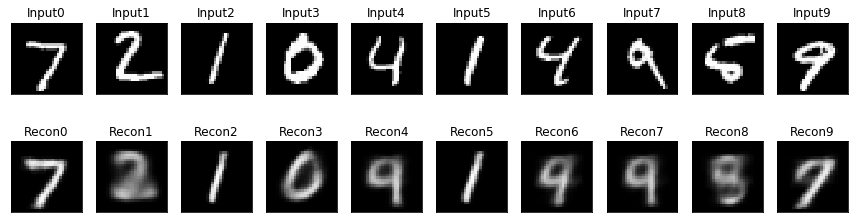

In [13]:
recon_x_test = vae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(28, 28),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

## 2D공간에 잠재된 데이터 출력

In [0]:
"""Plots labels and MNIST digits as a function of the 2D latent vector
# Arguments
    models (tuple): encoder and decoder models
    data (tuple): test data and label
    batch_size (int): prediction batch size
    model_name (string): which model is using this function
"""

# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    filename = "vae_mean.png"
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    #filename = os.path.join(model_name, "digits_over_latent.png")
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

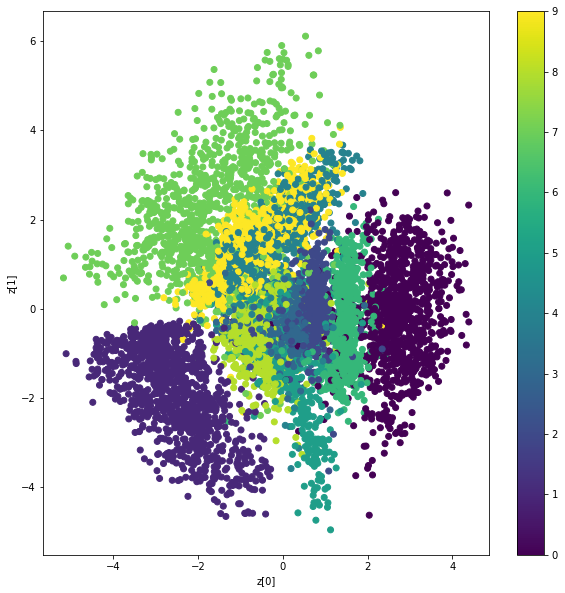

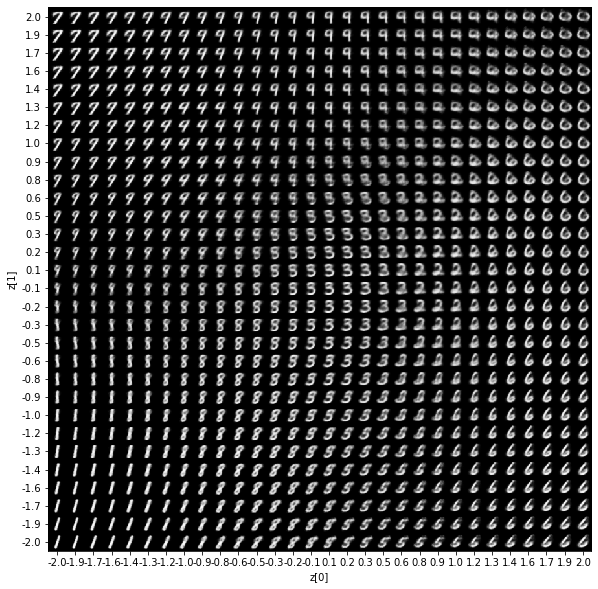

In [15]:
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

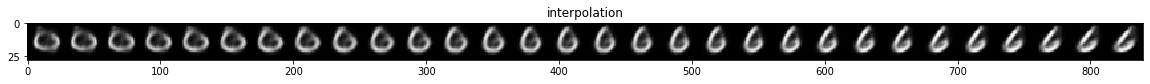

In [16]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

canvas = np.empty((28, 28*n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_hat = decoder.predict(z_sample)
        canvas[:, i*28: (i+1)*28] = x_hat[0].reshape(28, 28)
fig, ax = plt.subplots(figsize=(20,20))             
plt.title("interpolation")
ax.imshow(canvas, cmap="gray") 

# Reference
*   https://github.com/shanecandoit/vae-keras/blob/master/vae_mnist.ipynb
*   https://blog.keras.io/building-autoencoders-in-keras.html
*   https://keraskorea.github.io/posts/2018-10-23-keras_autoencoder/

